In [3]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
DATA_DIR = "../data/processed"
RESULTS_DIR = "../results"
ABLATION_DIR = os.path.join(RESULTS_DIR, "ablation_results")
os.makedirs(ABLATION_DIR, exist_ok=True)

print("✅ Directories ready.")

✅ Directories ready.


In [5]:
# Remove classes with too few samples
class_counts = y.value_counts()
valid_classes = class_counts[class_counts > 1].index
df = df[df["Label"].isin(valid_classes)]

print("✅ Removed rare classes. New shape:", df.shape)

# Split again with stratify
X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

✅ Removed rare classes. New shape: (99999, 72)
Train shape: (79999, 71)  Test shape: (20000, 71)


In [6]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"✅ {name} evaluated.")
    return pd.DataFrame(report).transpose()

In [8]:
from sklearn.preprocessing import LabelEncoder

for col in X_train.columns:
    if X_train[col].dtype == "object":
        le = LabelEncoder()
        # Fit only on train to prevent leakage
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

# 🔹 Train model using all features
rf_full = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_full.fit(X_train, y_train)

report_full = evaluate_model(rf_full, X_test, y_test, "Full Feature Model")
report_full["scenario"] = "all_features"


✅ Full Feature Model evaluated.


In [20]:
groups = {
    # Flow-level statistics (duration, bytes/s, packets/s, IAT)
    "Flow": [
        "Flow Duration", "Flow Bytes/s", "Flow Packets/s",
        "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min"
    ],
    
    # Forward traffic stats
    "Fwd": [
        "Total Fwd Packets", "Total Length of Fwd Packets",
        "Fwd Packet Length Max", "Fwd Packet Length Min", "Fwd Packet Length Mean", "Fwd Packet Length Std",
        "Fwd IAT Total", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min",
        "Fwd PSH Flags", "Fwd URG Flags", "Fwd Header Length", "Fwd Packets/s",
        "Avg Fwd Segment Size", "Fwd Header Length.1", "Init_Win_bytes_forward", "act_data_pkt_fwd", "min_seg_size_forward"
    ],
    
    # Backward traffic stats
    "Bwd": [
        "Total Backward Packets", "Total Length of Bwd Packets",
        "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean", "Bwd Packet Length Std",
        "Bwd IAT Total", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min",
        "Bwd Header Length", "Bwd Packets/s", "Avg Bwd Segment Size",
        "Init_Win_bytes_backward", "Subflow Bwd Packets", "Subflow Bwd Bytes"
    ],
    
    # Packet size & header stats
    "Pkt_Size": [
        "Min Packet Length", "Max Packet Length", "Packet Length Mean", "Packet Length Std", "Packet Length Variance",
        "Average Packet Size", "Subflow Fwd Packets", "Subflow Fwd Bytes"
    ],
    
    # TCP Flags
    "Flags": [
        "FIN Flag Count", "SYN Flag Count", "RST Flag Count", "PSH Flag Count", "ACK Flag Count",
        "URG Flag Count", "CWE Flag Count", "ECE Flag Count"
    ],
    
    # Activity timing
    "Activity": [
        "Active Mean", "Active Std", "Active Max", "Active Min",
        "Idle Mean", "Idle Std", "Idle Max", "Idle Min"
    ],
}

reports = [report_full] 

for group_name, cols in groups.items():
    drop_cols = [c for c in cols if c in X_train.columns]
    X_train_drop = X_train.drop(columns=drop_cols, errors="ignore")
    X_test_drop = X_test.drop(columns=drop_cols, errors="ignore")

    rf_ablate = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_ablate.fit(X_train_drop, y_train)
    
    report = evaluate_model(rf_ablate, X_test_drop, y_test, f"Ablation: no_{group_name}")
    report["scenario"] = f"no_{group_name}"
    reports.append(report)

print("✅ Ablation runs complete.")

✅ Ablation: no_Flow evaluated.
✅ Ablation: no_Fwd evaluated.
✅ Ablation: no_Bwd evaluated.
✅ Ablation: no_Pkt_Size evaluated.
✅ Ablation: no_Flags evaluated.
✅ Ablation: no_Activity evaluated.
✅ Ablation runs complete.


In [21]:
flat_reports = []

for report_df in reports:
    # Each 'report_df' is a DataFrame from the evaluation
    scenario_name = report_df["scenario"].iloc[0]  # Get scenario name from the column
    
    # Extract accuracy (it's in a row labeled 'accuracy')
    accuracy = report_df.loc["accuracy", "f1-score"] 
    
    # Extract macro-averaged scores from the 'macro avg' row
    macro_avg_stats = report_df.loc["macro avg"]
    
    flat_reports.append({
        "scenario": scenario_name,
        "accuracy": accuracy,
        "f1_macro": macro_avg_stats["f1-score"],
        "precision_macro": macro_avg_stats["precision"],
        "recall_macro": macro_avg_stats["recall"]
    })

df_reports = pd.DataFrame(flat_reports).sort_values(by="accuracy", ascending=False)
display(df_reports)

,scenario,accuracy,f1_macro,precision_macro,recall_macro
1,no_Flow,0.99870,0.883723,0.903098,0.867973
4,no_Pkt_Size,0.99840,0.876216,0.899062,0.859008
0,all_features,0.99835,0.872070,0.901084,0.850284
2,no_Fwd,0.99835,0.886275,0.914371,0.864013
5,no_Flags,0.99830,0.880507,0.907960,0.859506
6,no_Activity,0.99830,0.872522,0.900017,0.852212
3,no_Bwd,0.99825,0.872605,0.892545,0.856322


C:\Users\bhand\AppData\Local\Temp\ipykernel_10744\2030039742.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


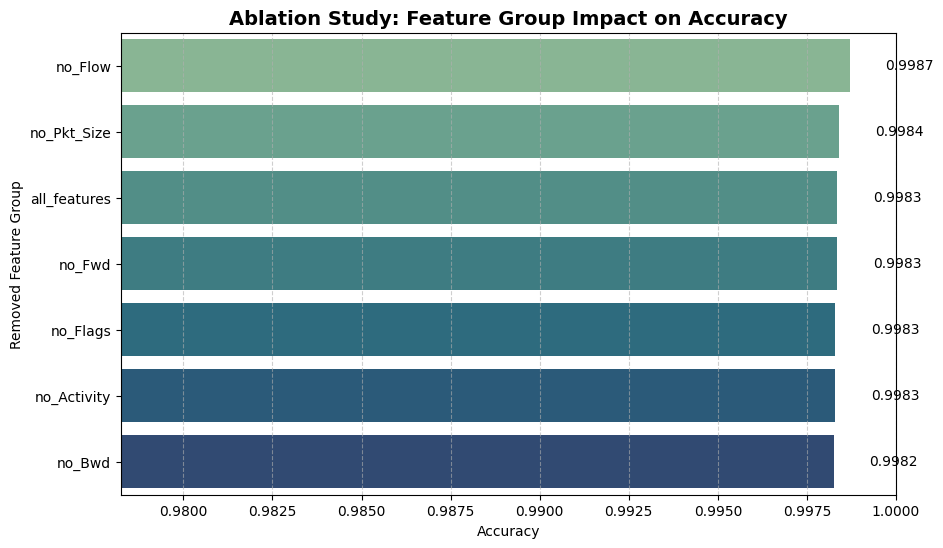

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Improvement: Find the minimum accuracy to set a dynamic plot range ---
min_accuracy = df_reports["accuracy"].min()
# Set a dynamic lower limit, e.g., 2% less than the minimum score
plot_lower_bound = max(0, min_accuracy - 0.02) 

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_reports,
    x="accuracy",
    y="scenario",
    palette="crest"
)

plt.title("Ablation Study: Feature Group Impact on Accuracy", fontsize=14, weight="bold")
plt.xlabel("Accuracy")
plt.ylabel("Removed Feature Group")
# --- Improvement: Use the dynamic range ---
plt.xlim(plot_lower_bound, 1.0) 
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Annotate each bar with its value
for bar in barplot.patches:
    plt.text(
        bar.get_width() + 0.001, # Position text slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2, # Center text vertically
        f'{bar.get_width():.4f}', # Format the value
        va='center'
    )

plt.show()